In [1]:
import math
import copy 
import numpy as np
from scipy.special import erfinv
from scipy.stats import norm
from scipy.optimize import fsolve
from scipy.optimize import bisect
import numpy.random as rng
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from copy import deepcopy 
from tqdm import tqdm
import time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

c:\Users\97255\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Related Functions

## Data generator

In [2]:
class Generator_doubleNormal(object):
    def __init__(self, p, theta, sigma0, sigma1, sigma=1) -> None:
        self.p = p 
        self.theta = theta 
        self.sigma0 = sigma0
        self.sigma1 = sigma1 
        self.sigma = sigma
        self.X = np.eye(p)
    
    def generate_samples(self, n):
        theta = np.ones((n, self.p)) * self.theta
        gamma = rng.binomial(1, theta)
        beta = np.zeros((n, self.p))
        beta[gamma == 1] = rng.randn(np.sum(gamma == 1)) * self.sigma1
        beta[gamma == 0] = rng.randn(np.sum(gamma == 0)) * self.sigma0 
        Y = beta@self.X.T + rng.randn(n, self.p) * self.sigma 
        return gamma, beta, Y 

Distribution related parameters are defined below. Training set are used to estimate the mean and standard deviation of Y, which are used to normalize the input to the Neural Network.

In [3]:
theta = 0.05
sigma0 = 0.1
sigma1 = 5
sigma = 1
lr = 0.001 # learning rate
p = 50
generator = Generator_doubleNormal(p, theta, sigma0, sigma1)

rng.seed(0)
gamma_train, beta_train, Y_train = generator.generate_samples(1000000)
gamma_val, beta_val, Y_val = generator.generate_samples(10000)

rng.seed(1)
gamma_test, beta_test, Y_test = generator.generate_samples(1000000)

mean = Y_train.mean(0)
std = Y_train.std(0)

val_dataset = TensorDataset(torch.Tensor((Y_val - mean) / std), torch.Tensor(beta_val))
valid_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))

Y_test_normalized = (Y_test - mean) / std

## True Posterior Computation

In [3]:
'''
The posterior is also a Gaussian mixture of two components. The posterior mean is easy to compute. However, the 
quantile doesn't have close form solution. Use fsolve in scipy.optimize to solve equations for quantile.
'''
def computeNormalStats(sigma, sigma0, sigma1, Y):
    tau = 1 / sigma**2
    tau0 = 1 / sigma0**2
    tau1 = 1 / sigma1**2
    tau0_ = tau0 + tau 
    tau1_ = tau1 + tau 
    theta_ = theta / (theta + (1-theta) * np.sqrt(tau1_*tau0/(tau0_*tau1)) \
        * np.exp(-0.5 * tau**2 * (tau0_-tau1_) / (tau0_*tau1_) * Y**2))
    mu1 = tau / tau1_ * Y 
    mu0 = tau / tau0_ * Y 
    true_mean = theta_ * mu1 + (1-theta_) * mu0
    # Use different initial values according to Y to avoid solver failure.
    if np.abs(Y) > 4:
        q025 = fsolve(lambda x: theta_ * norm.cdf(x, mu1, (1/tau1_)**0.5) + (1-theta_) * norm.cdf(x, mu0, (1/tau0_)**0.5) - 0.025, Y)
        q975 = fsolve(lambda x: theta_ * norm.cdf(x, mu1, (1/tau1_)**0.5) + (1-theta_) * norm.cdf(x, mu0, (1/tau0_)**0.5) - 0.975, Y)
    else:
        q025 = fsolve(lambda x: theta_ * norm.cdf(x, mu1, (1/tau1_)**0.5) + (1-theta_) * norm.cdf(x, mu0, (1/tau0_)**0.5) - 0.025, 0)
        q975 = fsolve(lambda x: theta_ * norm.cdf(x, mu1, (1/tau1_)**0.5) + (1-theta_) * norm.cdf(x, mu0, (1/tau0_)**0.5) - 0.975, 0)        
    return true_mean, q025, q975

# Neural Network Related Functions

## Model

In [4]:
class MLP_variant(nn.Module):
    def __init__(self, N, p, num_nodes, ac_func='relu', dropout=0):
        super(MLP_variant, self).__init__()
        fc = []
        last_node = N
        for node in num_nodes:
            fc.append(nn.Linear(last_node, node))
            last_node = node 
        self.fc_final = nn.Linear(last_node, p)
        self.fc = nn.ModuleList(fc)
        assert ac_func in ('relu', 'tanh', 'leakyrelu', 'softplus', 'softsign', 'selu', 'elu')
        if ac_func == 'relu':
            self.activation = nn.ReLU()
        elif ac_func == 'tanh':
            self.activation = nn.Tanh()
        elif ac_func == 'leakyrelu':
            self.activation = nn.LeakyReLU()
        elif ac_func == 'softplus':
            self.activation = nn.Softplus()
        elif ac_func == 'softsign':
            self.activation = nn.Softsign()
        elif ac_func == 'selu':
            self.activation = nn.SELU()
        elif ac_func == 'elu':
            self.activation = nn.ELU()
        self.mseloss = nn.MSELoss()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        for m in self.fc:
            x = self.dropout(self.activation(m(x)))
        x = self.fc_final(x)
        return x 
    
    def get_mseloss(self, data, targ):
        output = self.forward(data)
        loss = self.mseloss(output, targ)
        return loss 

    def get_quanloss(self, data, targ, tau):
        output = self.forward(data)
        errs = targ - output 
        loss = torch.mean(torch.max((tau-1)*errs, tau*errs))
        return loss       

    def get_max_quanloss(self, data, targ, tau):
        output = self.forward(data)
        errs = targ - output 
        # print(torch.mean(torch.max((tau-1)*errs, tau*errs), dim=0).shape) # expect: p
        loss = torch.max(torch.mean(torch.max((tau-1)*errs, tau*errs), dim=0))
        return loss 

## Training/Evaluation functions

In [5]:
def model_test(model, data_loader, loss_type='mse', q=0.5, kwargs=None):
    model.eval()
    with torch.no_grad():
        n = 0 
        total_loss = 0.
        for _, (data, targ) in enumerate(data_loader):
            data, targ = data.to(device), targ.to(device)
            if kwargs:
                if 'subset' in kwargs:
                    targ = targ[:,(kwargs['subset'][0]-1):kwargs['subset'][1]]
            if loss_type == 'mse':
                loss = model.get_mseloss(data, targ)
            elif loss_type == 'bce':
                loss = model.get_bceloss(data, targ)
            elif loss_type == 'quantile':
                loss = model.get_quanloss(data, targ, q)
            elif loss_type == 'max_quantile':
                loss = model.get_max_quanloss(data, targ, q)
            total_loss += loss.item() * data.shape[0]
            n += data.shape[0]
    return total_loss/n

def predict(model, Y):
    model.eval()
    with torch.no_grad():
        data = torch.from_numpy(Y).type(torch.float).to(device)
        pred = model(data)
    return pred.detach().cpu().numpy()

def show_loss(train_losses, val_losses):
    plt.plot(range(len(train_losses)), train_losses)
    plt.plot(range(len(train_losses)), val_losses)
    plt.legend(['train loss', 'val loss'], loc="upper right")
    plt.show()

def predict_class(model, Y):
    model.eval()
    with torch.no_grad():
        data = torch.from_numpy(Y).type(torch.float).to(device)
        pred = torch.sigmoid(model(data))
    return pred.detach().cpu().numpy()

In [6]:
'''
The following training function uses fixed training data.
'''
''' 
loss_type: 'mse' for posterior mean, 'bce' for predicting whether beta is 0, 'quantile' for posterior quantile.
q: Only used when loss_type is 'quantile', q quantile.
'''
def train_epoch(model, optimizer, data_loader, loss_type, q, kwargs):
    model.train()
    n = 0
    train_loss = 0.
    for _, (data, targ) in enumerate(data_loader):
        data, targ = data.to(device), targ.to(device)
        if loss_type == 'mse':
            loss = model.get_mseloss(data, targ)
        elif loss_type == 'bce':
            loss = model.get_bceloss(data, targ)
        elif loss_type == 'quantile':
            loss = model.get_quanloss(data, targ, q)
        elif loss_type == 'max_quantile':
            loss = model.get_max_quanloss(data, targ, q)
        train_loss += loss.item() * data.shape[0]   
        n += data.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if 'scheduler' in kwargs:
        kwargs['scheduler'].step()
    return train_loss/n
             
def train_model(model, model_es, optimizer, epochs, train_data, loss_type='mse', q=0.5, val_data=None, early_stop=10, **kwargs):
    assert loss_type in ['mse', 'bce', 'quantile', 'max_quantile']
    train_losses = []
    val_losses = []
    min_loss = 1e6
    es_count = 0
    es_flag = 0
    for i in range(epochs):
        train_loss = train_epoch(model, optimizer, train_data, loss_type, q, kwargs)
        print('Epoch: {}'.format(i+1))
        print('Train loss: {:.5f}'.format(train_loss))
        train_losses.append(train_loss)
        if val_data.__str__() != 'None':
            val_loss = model_test(model, val_data, loss_type, q)
            print('Val loss: {:.5f}'.format(val_loss))
            val_losses.append(val_loss)
            if val_loss <= min_loss:
                min_loss = val_loss
                es_count = 0
            if (es_count >= early_stop) and (es_flag == 0):
                es_flag = 1
                print('Save early stopping model at epoch {}'.format(i+1))
                model_es.load_state_dict(deepcopy(model.state_dict()))
            es_count += 1
    return train_losses, val_losses

In [7]:
'''
The following training function uses brand new samples at each batch.
'''
def train_epoch_with_generator(model, optimizer, generator, batch_size, iteration, loss_type, q, kwargs):
    model.train()
    train_loss = 0.
    for i in range(iteration):
        gamma, beta, Y = generator.generate_samples(batch_size)
        Y = (Y - kwargs['mean']) / kwargs['std']

        if 'subset' in kwargs:
            gamma = torch.from_numpy(gamma[:,(kwargs['subset'][0]-1):kwargs['subset'][1]]).type(torch.float).to(device)
            beta = torch.from_numpy(beta[:,(kwargs['subset'][0]-1):kwargs['subset'][1]]).type(torch.float).to(device)
            Y = torch.from_numpy(Y).type(torch.float).to(device)
        else:
            gamma = torch.from_numpy(gamma).type(torch.float).to(device)
            beta = torch.from_numpy(beta).type(torch.float).to(device)
            Y = torch.from_numpy(Y).type(torch.float).to(device)

        if loss_type == 'mse':
            loss = model.get_mseloss(Y, beta)
        elif loss_type == 'bce':
            loss = model.get_bceloss(Y, gamma)
        elif loss_type == 'quantile':
            loss = model.get_quanloss(Y, beta, q)
        elif loss_type == 'max_quantile':
            loss = model.get_max_quanloss(Y, beta, q)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if 'scheduler' in kwargs:
        kwargs['scheduler'].step()
    return train_loss/(i+1)

# Input mean and std to normalize input.
# Input subset to take a subset of coordinates.
def train_model_with_generator(model, generator, optimizer, epochs, batch_size, iteration_per_epoch, loss_type='mse', q=0.5, val_data=None, **kwargs):
    assert loss_type in ['mse', 'bce', 'quantile', 'max_quantile']
    train_losses = []
    val_losses = []
    for i in range(epochs):
        train_loss = train_epoch_with_generator(
            model, optimizer, generator, batch_size, iteration_per_epoch, loss_type, q, kwargs)
        print('Epoch: {}'.format(i+1))
        print('Train loss: {:.5f}'.format(train_loss))
        train_losses.append(train_loss)
        if val_data.__str__() != 'None':
            val_loss = model_test(model, val_data, loss_type, q, kwargs)
            print('Val loss: {:.5f}'.format(val_loss))
            val_losses.append(val_loss)
        if 'model_list' in kwargs:
            if (i+1) in kwargs['save_point']:
                kwargs['model_list'].append(deepcopy(model.state_dict()))
    return train_losses, val_losses

# Gold Standard Computation

In [9]:
'''
Only the first 10,000 test samples are used for comparison. 
'''
true_mean = np.zeros((10000, p))
true_q025 = np.zeros((10000, p))
true_q975 = np.zeros((10000, p))

for i in tqdm(range(10000)):
    for j in range(p):
        true_mean[i,j], true_q025[i,j], true_q975[i,j] = computeNormalStats(sigma, sigma0, sigma1, Y_test[i,j])

100%|██████████| 10000/10000 [25:11<00:00,  6.62it/s]


# Main Experiments

## Use max coordinate loss

In [9]:
md_q025 = MLP_variant(p, p, [1024, 1024], 'leakyrelu').to(device) 
optimizer = torch.optim.Adam(md_q025.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30, 40, 50, 60, 70, 80], gamma=0.4)
train_losses, val_losses = train_model_with_generator(md_q025, generator, optimizer, epochs=100, 
                                      batch_size=256, iteration_per_epoch=4000, loss_type='max_quantile',
                                      q=0.025, val_data=valid_dataloader, scheduler=scheduler, mean=mean, std=std)

Epoch: 1
Train loss: 0.08004
Val loss: 0.04620
Epoch: 2
Train loss: 0.05043
Val loss: 0.03754
Epoch: 3
Train loss: 0.04656
Val loss: 0.04080
Epoch: 4
Train loss: 0.04460
Val loss: 0.03537
Epoch: 5
Train loss: 0.04376
Val loss: 0.03635
Epoch: 6
Train loss: 0.04343
Val loss: 0.03631
Epoch: 7
Train loss: 0.04311
Val loss: 0.03490
Epoch: 8
Train loss: 0.04263
Val loss: 0.03455
Epoch: 9
Train loss: 0.04257
Val loss: 0.03523
Epoch: 10
Train loss: 0.04228
Val loss: 0.03677
Epoch: 11
Train loss: 0.04201
Val loss: 0.03237
Epoch: 12
Train loss: 0.04153
Val loss: 0.03264
Epoch: 13
Train loss: 0.04154
Val loss: 0.03195
Epoch: 14
Train loss: 0.04098
Val loss: 0.03268
Epoch: 15
Train loss: 0.04087
Val loss: 0.03043
Epoch: 16
Train loss: 0.04075
Val loss: 0.03432
Epoch: 17
Train loss: 0.04046
Val loss: 0.03402
Epoch: 18
Train loss: 0.04006
Val loss: 0.03720
Epoch: 19
Train loss: 0.04003
Val loss: 0.03107
Epoch: 20
Train loss: 0.03990
Val loss: 0.03111
Epoch: 21
Train loss: 0.03700
Val loss: 0.02712
E

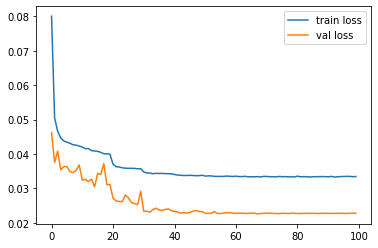

In [10]:
show_loss(train_losses, val_losses)

In [11]:
md_q975 = MLP_variant(p, p, [1024, 1024], 'leakyrelu').to(device) 
optimizer = torch.optim.Adam(md_q975.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30, 40, 50, 60, 70, 80], gamma=0.4)
train_losses, val_losses = train_model_with_generator(md_q975, generator, optimizer, epochs=100, 
                                      batch_size=256, iteration_per_epoch=4000, loss_type='max_quantile',
                                      q=0.975, val_data=valid_dataloader, scheduler=scheduler, mean=mean, std=std)

Epoch: 1
Train loss: 0.08090
Val loss: 0.04505
Epoch: 2
Train loss: 0.05103
Val loss: 0.04011
Epoch: 3
Train loss: 0.04728
Val loss: 0.03794
Epoch: 4
Train loss: 0.04489
Val loss: 0.03516
Epoch: 5
Train loss: 0.04388
Val loss: 0.03597
Epoch: 6
Train loss: 0.04321
Val loss: 0.03448
Epoch: 7
Train loss: 0.04286
Val loss: 0.03493
Epoch: 8
Train loss: 0.04273
Val loss: 0.03363
Epoch: 9
Train loss: 0.04240
Val loss: 0.03519
Epoch: 10
Train loss: 0.04191
Val loss: 0.03311
Epoch: 11
Train loss: 0.04150
Val loss: 0.03600
Epoch: 12
Train loss: 0.04141
Val loss: 0.03017
Epoch: 13
Train loss: 0.04112
Val loss: 0.03494
Epoch: 14
Train loss: 0.04080
Val loss: 0.03130
Epoch: 15
Train loss: 0.04051
Val loss: 0.03414
Epoch: 16
Train loss: 0.04048
Val loss: 0.03223
Epoch: 17
Train loss: 0.04007
Val loss: 0.03233
Epoch: 18
Train loss: 0.04002
Val loss: 0.03040
Epoch: 19
Train loss: 0.03975
Val loss: 0.03131
Epoch: 20
Train loss: 0.03955
Val loss: 0.03215
Epoch: 21
Train loss: 0.03706
Val loss: 0.02639
E

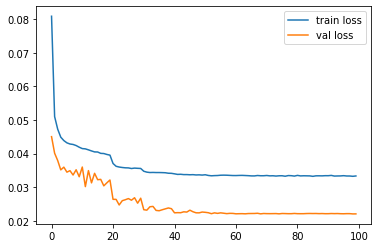

In [12]:
show_loss(train_losses, val_losses)

In [15]:
true_q025 = np.load('data/gs_q025.npy')
true_q975 = np.load('data/gs_q975.npy')
true_mean = np.load('data/gs_mean.npy')

In [18]:
pred_q025 = predict(md_q025, Y_test_normalized)
pred_q975 = predict(md_q975, Y_test_normalized)

In [19]:
mse_q025 = np.mean((true_q025 - pred_q025[:10000,:])**2, 0)
mse_q975 = np.mean((true_q975 - pred_q975[:10000,:])**2, 0)

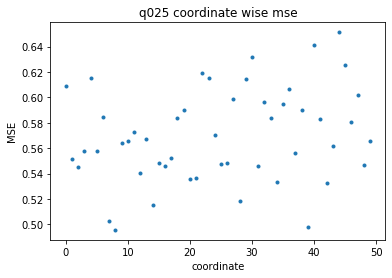

In [20]:
plt.plot(mse_q025,'.')
plt.xlabel('coordinate')
plt.ylabel('MSE')
plt.title('q025 coordinate wise mse')
plt.show()

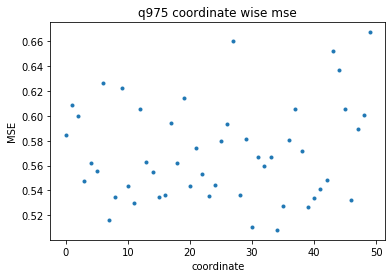

In [21]:
plt.plot(mse_q975,'.')
plt.xlabel('coordinate')
plt.ylabel('MSE')
plt.title('q975 coordinate wise mse')
plt.show()

### TODO: Need to tune parameters

## Larger p

In [22]:
del gamma_train, beta_train, Y_train
del gamma_val, beta_val, Y_val
del gamma_test, beta_test, Y_test
del val_dataset, valid_dataloader, Y_test_normalized

In [8]:
theta = 0.05
sigma0 = 0.1
sigma1 = 5
sigma = 1
lr = 0.001 # learning rate
p = 500
generator = Generator_doubleNormal(p, theta, sigma0, sigma1)

rng.seed(0)
gamma_val, beta_val, Y_val = generator.generate_samples(10000)

rng.seed(1)
gamma_test, beta_test, Y_test = generator.generate_samples(100000)

mean = 0
std = 1.5

val_dataset = TensorDataset(torch.Tensor((Y_val - mean) / std), torch.Tensor(beta_val))
valid_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))

Y_test_normalized = (Y_test - mean) / std

In [9]:
'''
Only the first 10,000 test samples are used for comparison. 
'''
true_mean = np.zeros((10000, 20))
true_q025 = np.zeros((10000, 20))
true_q975 = np.zeros((10000, 20))

for i in tqdm(range(10000)):
    for j in range(20):
        true_mean[i,j], true_q025[i,j], true_q975[i,j] = computeNormalStats(sigma, sigma0, sigma1, Y_test[i,j])

100%|██████████| 10000/10000 [06:37<00:00, 25.18it/s]


In [11]:
np.save('./data/gs_p500_s20_mean', true_mean)
np.save('./data/gs_p500_s20_q025', true_q025)
np.save('./data/gs_p500_s20_q975', true_q975)

In [9]:
true_q025 = np.load('./data/gs_p500_s20_q025.npy') 
true_q975 = np.load('./data/gs_p500_s20_q975.npy') 

In [27]:
s = (1, 20)
md_q025_1_20 = MLP_variant(p, 20, [1024, 1024], 'leakyrelu').to(device)
optimizer = torch.optim.Adam(md_q025_1_20.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30, 40, 50, 60, 70, 80], gamma=0.4)
train_losses, val_losses = train_model_with_generator(md_q025_1_20, generator, optimizer, epochs=100, 
                                      batch_size=256, iteration_per_epoch=4000, loss_type='quantile',
                                      q=0.025, val_data=valid_dataloader, scheduler=scheduler,
                                      mean=mean, std=std, subset=s)

Epoch: 1
Train loss: 0.02407
Val loss: 0.02036
Epoch: 2
Train loss: 0.02053
Val loss: 0.02026
Epoch: 3
Train loss: 0.02018
Val loss: 0.01989
Epoch: 4
Train loss: 0.01996
Val loss: 0.01954
Epoch: 5
Train loss: 0.01985
Val loss: 0.01941
Epoch: 6
Train loss: 0.01984
Val loss: 0.01983
Epoch: 7
Train loss: 0.01982
Val loss: 0.01965
Epoch: 8
Train loss: 0.01980
Val loss: 0.01969
Epoch: 9
Train loss: 0.01972
Val loss: 0.01946
Epoch: 10
Train loss: 0.01972
Val loss: 0.01963
Epoch: 11
Train loss: 0.01972
Val loss: 0.01945
Epoch: 12
Train loss: 0.01969
Val loss: 0.01935
Epoch: 13
Train loss: 0.01970
Val loss: 0.01958
Epoch: 14
Train loss: 0.01967
Val loss: 0.01929
Epoch: 15
Train loss: 0.01962
Val loss: 0.01936
Epoch: 16
Train loss: 0.01962
Val loss: 0.01927
Epoch: 17
Train loss: 0.01963
Val loss: 0.01936
Epoch: 18
Train loss: 0.01961
Val loss: 0.01937
Epoch: 19
Train loss: 0.01955
Val loss: 0.01928
Epoch: 20
Train loss: 0.01957
Val loss: 0.01944
Epoch: 21
Train loss: 0.01876
Val loss: 0.01825
E

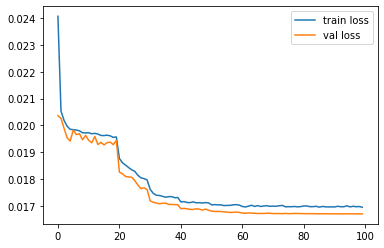

In [28]:
show_loss(train_losses, val_losses)

In [29]:
torch.save(md_q025_1_20.state_dict(), 'model/p500_s20_q025.pt')

Epoch: 1
Train loss: 0.02413
Val loss: 0.02105
Epoch: 2
Train loss: 0.02049
Val loss: 0.02057
Epoch: 3
Train loss: 0.02018
Val loss: 0.02056
Epoch: 4
Train loss: 0.02001
Val loss: 0.02039
Epoch: 5
Train loss: 0.01994
Val loss: 0.02025
Epoch: 6
Train loss: 0.01995
Val loss: 0.02020
Epoch: 7
Train loss: 0.01993
Val loss: 0.02006
Epoch: 8
Train loss: 0.01985
Val loss: 0.02017
Epoch: 9
Train loss: 0.01989
Val loss: 0.02022
Epoch: 10
Train loss: 0.01982
Val loss: 0.02004
Epoch: 11
Train loss: 0.01984
Val loss: 0.02017
Epoch: 12
Train loss: 0.01982
Val loss: 0.02025
Epoch: 13
Train loss: 0.01979
Val loss: 0.02025
Epoch: 14
Train loss: 0.01976
Val loss: 0.02020
Epoch: 15
Train loss: 0.01977
Val loss: 0.02005
Epoch: 16
Train loss: 0.01973
Val loss: 0.02004
Epoch: 17
Train loss: 0.01968
Val loss: 0.02011
Epoch: 18
Train loss: 0.01968
Val loss: 0.02009
Epoch: 19
Train loss: 0.01970
Val loss: 0.02021
Epoch: 20
Train loss: 0.01962
Val loss: 0.02012
Epoch: 21
Train loss: 0.01891
Val loss: 0.01904
E

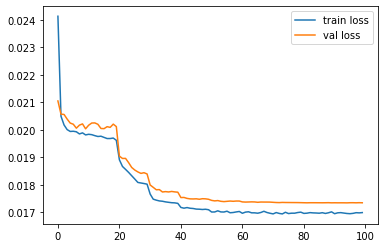

Epoch: 1
Train loss: 0.02370
Val loss: 0.01990
Epoch: 2
Train loss: 0.01935
Val loss: 0.01927
Epoch: 3
Train loss: 0.01959
Val loss: 0.01968
Epoch: 4
Train loss: 0.01871
Val loss: 0.01937
Epoch: 5
Train loss: 0.01850
Val loss: 0.01898
Epoch: 6
Train loss: 0.01853
Val loss: 0.01972
Epoch: 7
Train loss: 0.01860
Val loss: 0.01787
Epoch: 8
Train loss: 0.01827
Val loss: 0.01888
Epoch: 9
Train loss: 0.01834
Val loss: 0.01855
Epoch: 10
Train loss: 0.01826
Val loss: 0.01905
Epoch: 11
Train loss: 0.01823
Val loss: 0.01898
Epoch: 12
Train loss: 0.01831
Val loss: 0.01848
Epoch: 13
Train loss: 0.01819
Val loss: 0.01873
Epoch: 14
Train loss: 0.01817
Val loss: 0.01848
Epoch: 15
Train loss: 0.01824
Val loss: 0.01940
Epoch: 16
Train loss: 0.01809
Val loss: 0.01921
Epoch: 17
Train loss: 0.01826
Val loss: 0.01894
Epoch: 18
Train loss: 0.01798
Val loss: 0.01833
Epoch: 19
Train loss: 0.01808
Val loss: 0.01878
Epoch: 20
Train loss: 0.01823
Val loss: 0.01804
Epoch: 21
Train loss: 0.01746
Val loss: 0.01773
E

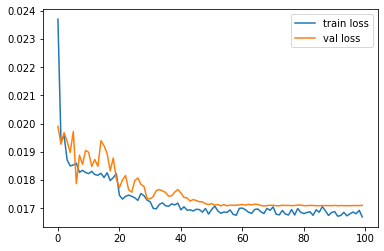

Epoch: 1
Train loss: 0.02349
Val loss: 0.01909
Epoch: 2
Train loss: 0.01937
Val loss: 0.01948
Epoch: 3
Train loss: 0.01894
Val loss: 0.01885
Epoch: 4
Train loss: 0.01884
Val loss: 0.01860
Epoch: 5
Train loss: 0.01862
Val loss: 0.01785
Epoch: 6
Train loss: 0.01847
Val loss: 0.01845
Epoch: 7
Train loss: 0.01836
Val loss: 0.01906
Epoch: 8
Train loss: 0.01846
Val loss: 0.01946
Epoch: 9
Train loss: 0.01851
Val loss: 0.01874
Epoch: 10
Train loss: 0.01835
Val loss: 0.01862
Epoch: 11
Train loss: 0.01827
Val loss: 0.01838
Epoch: 12
Train loss: 0.01829
Val loss: 0.01843
Epoch: 13
Train loss: 0.01816
Val loss: 0.01867
Epoch: 14
Train loss: 0.01816
Val loss: 0.01872
Epoch: 15
Train loss: 0.01813
Val loss: 0.01833
Epoch: 16
Train loss: 0.01807
Val loss: 0.01783
Epoch: 17
Train loss: 0.01801
Val loss: 0.01806
Epoch: 18
Train loss: 0.01826
Val loss: 0.01787
Epoch: 19
Train loss: 0.01820
Val loss: 0.01799
Epoch: 20
Train loss: 0.01811
Val loss: 0.01824
Epoch: 21
Train loss: 0.01739
Val loss: 0.01803
E

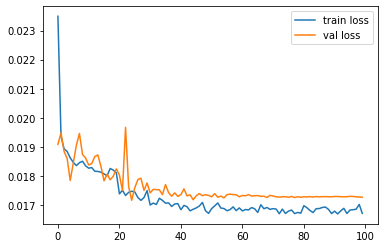

In [30]:
md_q975_1_20 = MLP_variant(p, 20, [1024, 1024], 'leakyrelu').to(device)
optimizer = torch.optim.Adam(md_q975_1_20.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30, 40, 50, 60, 70, 80], gamma=0.4)
train_losses, val_losses = train_model_with_generator(md_q975_1_20, generator, optimizer, epochs=100, 
                                      batch_size=256, iteration_per_epoch=4000, loss_type='quantile',
                                      q=0.975, val_data=valid_dataloader, scheduler=scheduler,
                                      mean=mean, std=std, subset=s)
show_loss(train_losses, val_losses)
s = (1, 1)
md_q025_1 = MLP_variant(p, 1, [1024, 1024], 'leakyrelu').to(device)
optimizer = torch.optim.Adam(md_q025_1.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30, 40, 50, 60, 70, 80], gamma=0.4)
train_losses, val_losses = train_model_with_generator(md_q025_1, generator, optimizer, epochs=100, 
                                      batch_size=256, iteration_per_epoch=4000, loss_type='quantile',
                                      q=0.025, val_data=valid_dataloader, scheduler=scheduler,
                                      mean=mean, std=std, subset=s)
show_loss(train_losses, val_losses)
md_q975_1 = MLP_variant(p, 1, [1024, 1024], 'leakyrelu').to(device)
optimizer = torch.optim.Adam(md_q975_1.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30, 40, 50, 60, 70, 80], gamma=0.4)
train_losses, val_losses = train_model_with_generator(md_q975_1, generator, optimizer, epochs=100, 
                                      batch_size=256, iteration_per_epoch=4000, loss_type='quantile',
                                      q=0.975, val_data=valid_dataloader, scheduler=scheduler,
                                      mean=mean, std=std, subset=s)
show_loss(train_losses, val_losses)
torch.save(md_q975_1_20.state_dict(), 'model/p500_s20_q975.pt')
torch.save(md_q025_1.state_dict(), 'model/p500_s1_q025.pt')
torch.save(md_q975_1.state_dict(), 'model/p500_s1_q975.pt')

In [11]:
md_q025_1_20 = MLP_variant(p, 20, [1024, 1024], 'leakyrelu').to(device)
md_q975_1_20 = MLP_variant(p, 20, [1024, 1024], 'leakyrelu').to(device)
md_q025_1 = MLP_variant(p, 1, [1024, 1024], 'leakyrelu').to(device)
md_q975_1 = MLP_variant(p, 1, [1024, 1024], 'leakyrelu').to(device)
md_q025_1_20.load_state_dict(torch.load('./model/p500_s20_q025.pt'))
md_q975_1_20.load_state_dict(torch.load('./model/p500_s20_q975.pt'))
md_q025_1.load_state_dict(torch.load('./model/p500_s1_q025.pt'))
md_q975_1.load_state_dict(torch.load('./model/p500_s1_q975.pt'))

<All keys matched successfully>

In [14]:
pred_q025 = predict(md_q025_1_20, Y_test_normalized)
pred_q975 = predict(md_q975_1_20, Y_test_normalized)

In [15]:
mse_q025 = np.mean((true_q025 - pred_q025[:10000,:20])**2, 0)
mse_q975 = np.mean((true_q975 - pred_q975[:10000,:20])**2, 0)

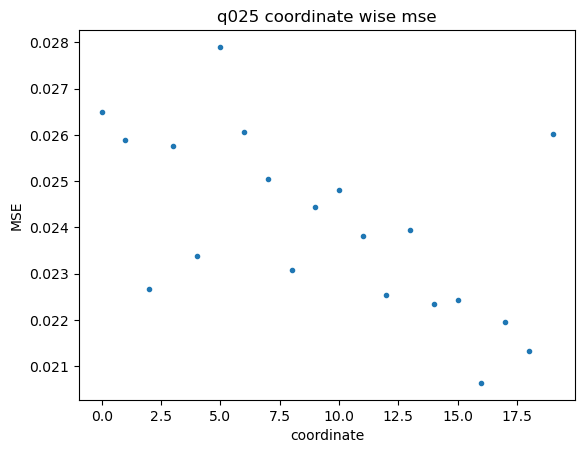

In [16]:
plt.plot(mse_q025,'.')
plt.xlabel('coordinate')
plt.ylabel('MSE')
plt.title('q025 coordinate wise mse')
plt.show()

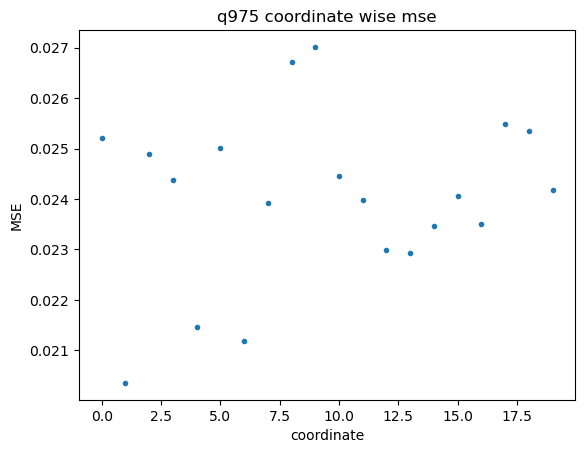

In [17]:
plt.plot(mse_q975,'.')
plt.xlabel('coordinate')
plt.ylabel('MSE')
plt.title('q975 coordinate wise mse')
plt.show()

In [19]:
pred_q025_1 = predict(md_q025_1, Y_test_normalized)
pred_q975_1 = predict(md_q975_1, Y_test_normalized)

In [20]:
print('q025: ', np.mean((true_q025[:,:1] - pred_q025_1[:10000,:])**2))
print('q975: ', np.mean((true_q975[:,:1] - pred_q975_1[:10000,:])**2))

q025:  0.01605065848583056
q975:  0.015550676924479347


## Original Model (output dimension = 50)

MLP_variant(input dimension, output dimension, hidden units, activation function)

In [10]:
md_q025 = MLP_variant(p, p, [1024, 1024], 'leakyrelu').to(device) 
optimizer = torch.optim.Adam(md_q025.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30, 40, 50, 60, 70, 80], gamma=0.4)
train_losses, val_losses = train_model_with_generator(md_q025, generator, optimizer, epochs=100, 
                                      batch_size=256, iteration_per_epoch=4000, loss_type='quantile',
                                      q=0.025, val_data=valid_dataloader, scheduler=scheduler, mean=mean, std=std)

Epoch: 1
Train loss: 0.02295
Val loss: 0.02030
Epoch: 2
Train loss: 0.01981
Val loss: 0.01972
Epoch: 3
Train loss: 0.01948
Val loss: 0.01945
Epoch: 4
Train loss: 0.01927
Val loss: 0.01927
Epoch: 5
Train loss: 0.01913
Val loss: 0.01922
Epoch: 6
Train loss: 0.01902
Val loss: 0.01911
Epoch: 7
Train loss: 0.01898
Val loss: 0.01903
Epoch: 8
Train loss: 0.01891
Val loss: 0.01904
Epoch: 9
Train loss: 0.01891
Val loss: 0.01892
Epoch: 10
Train loss: 0.01886
Val loss: 0.01908
Epoch: 11
Train loss: 0.01882
Val loss: 0.01898
Epoch: 12
Train loss: 0.01883
Val loss: 0.01894
Epoch: 13
Train loss: 0.01880
Val loss: 0.01889
Epoch: 14
Train loss: 0.01880
Val loss: 0.01890
Epoch: 15
Train loss: 0.01877
Val loss: 0.01883
Epoch: 16
Train loss: 0.01873
Val loss: 0.01889
Epoch: 17
Train loss: 0.01874
Val loss: 0.01880
Epoch: 18
Train loss: 0.01873
Val loss: 0.01877
Epoch: 19
Train loss: 0.01872
Val loss: 0.01893
Epoch: 20
Train loss: 0.01871
Val loss: 0.01882
Epoch: 21
Train loss: 0.01831
Val loss: 0.01835
E

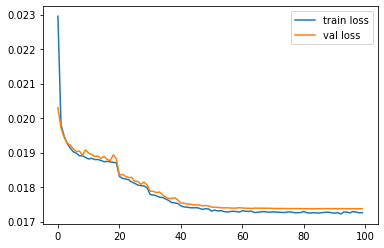

In [11]:
show_loss(train_losses, val_losses)

In [12]:
md_q975 = MLP_variant(p, p, [1024, 1024], 'leakyrelu').to(device)
optimizer = torch.optim.Adam(md_q975.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30, 40, 50, 60, 70, 80], gamma=0.4)
train_losses, val_losses = train_model_with_generator(md_q975, generator, optimizer, epochs=100, 
                                      batch_size=256, iteration_per_epoch=4000, loss_type='quantile',
                                      q=0.975, val_data=valid_dataloader, scheduler=scheduler, mean=mean, std=std)

Epoch: 1
Train loss: 0.02306
Val loss: 0.01980
Epoch: 2
Train loss: 0.01985
Val loss: 0.01932
Epoch: 3
Train loss: 0.01950
Val loss: 0.01899
Epoch: 4
Train loss: 0.01929
Val loss: 0.01890
Epoch: 5
Train loss: 0.01917
Val loss: 0.01887
Epoch: 6
Train loss: 0.01907
Val loss: 0.01878
Epoch: 7
Train loss: 0.01903
Val loss: 0.01854
Epoch: 8
Train loss: 0.01896
Val loss: 0.01860
Epoch: 9
Train loss: 0.01891
Val loss: 0.01857
Epoch: 10
Train loss: 0.01887
Val loss: 0.01861
Epoch: 11
Train loss: 0.01884
Val loss: 0.01852
Epoch: 12
Train loss: 0.01883
Val loss: 0.01848
Epoch: 13
Train loss: 0.01880
Val loss: 0.01846
Epoch: 14
Train loss: 0.01879
Val loss: 0.01847
Epoch: 15
Train loss: 0.01875
Val loss: 0.01848
Epoch: 16
Train loss: 0.01873
Val loss: 0.01841
Epoch: 17
Train loss: 0.01872
Val loss: 0.01850
Epoch: 18
Train loss: 0.01871
Val loss: 0.01841
Epoch: 19
Train loss: 0.01871
Val loss: 0.01833
Epoch: 20
Train loss: 0.01867
Val loss: 0.01838
Epoch: 21
Train loss: 0.01828
Val loss: 0.01795
E

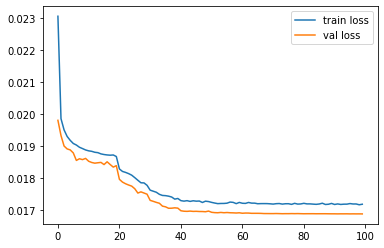

In [13]:
show_loss(train_losses, val_losses)

In [14]:
md_mean = MLP_variant(p, p, [1024, 1024], 'leakyrelu').to(device)
optimizer = torch.optim.Adam(md_mean.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30, 40, 50, 60, 70, 80], gamma=0.4)
train_losses, val_losses = train_model_with_generator(md_mean, generator, optimizer, epochs=100, 
                                      batch_size=256, iteration_per_epoch=4000, loss_type='mse',
                                      val_data=valid_dataloader, scheduler=scheduler, mean=mean, std=std)

Epoch: 1
Train loss: 0.18590
Val loss: 0.14285
Epoch: 2
Train loss: 0.14081
Val loss: 0.13850
Epoch: 3
Train loss: 0.13863
Val loss: 0.13708
Epoch: 4
Train loss: 0.13749
Val loss: 0.13610
Epoch: 5
Train loss: 0.13703
Val loss: 0.13653
Epoch: 6
Train loss: 0.13664
Val loss: 0.13542
Epoch: 7
Train loss: 0.13634
Val loss: 0.13508
Epoch: 8
Train loss: 0.13600
Val loss: 0.13490
Epoch: 9
Train loss: 0.13579
Val loss: 0.13459
Epoch: 10
Train loss: 0.13583
Val loss: 0.13489
Epoch: 11
Train loss: 0.13559
Val loss: 0.13522
Epoch: 12
Train loss: 0.13515
Val loss: 0.13381
Epoch: 13
Train loss: 0.13517
Val loss: 0.13397
Epoch: 14
Train loss: 0.13491
Val loss: 0.13386
Epoch: 15
Train loss: 0.13489
Val loss: 0.13441
Epoch: 16
Train loss: 0.13477
Val loss: 0.13469
Epoch: 17
Train loss: 0.13476
Val loss: 0.13363
Epoch: 18
Train loss: 0.13444
Val loss: 0.13381
Epoch: 19
Train loss: 0.13441
Val loss: 0.13388
Epoch: 20
Train loss: 0.13409
Val loss: 0.13323
Epoch: 21
Train loss: 0.12955
Val loss: 0.12830
E

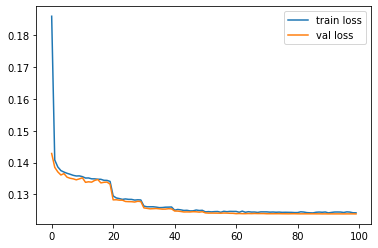

In [15]:
show_loss(train_losses, val_losses)

### Show comparison between true posterior and predicted of randomly chosen test samples (has non-zero beta)

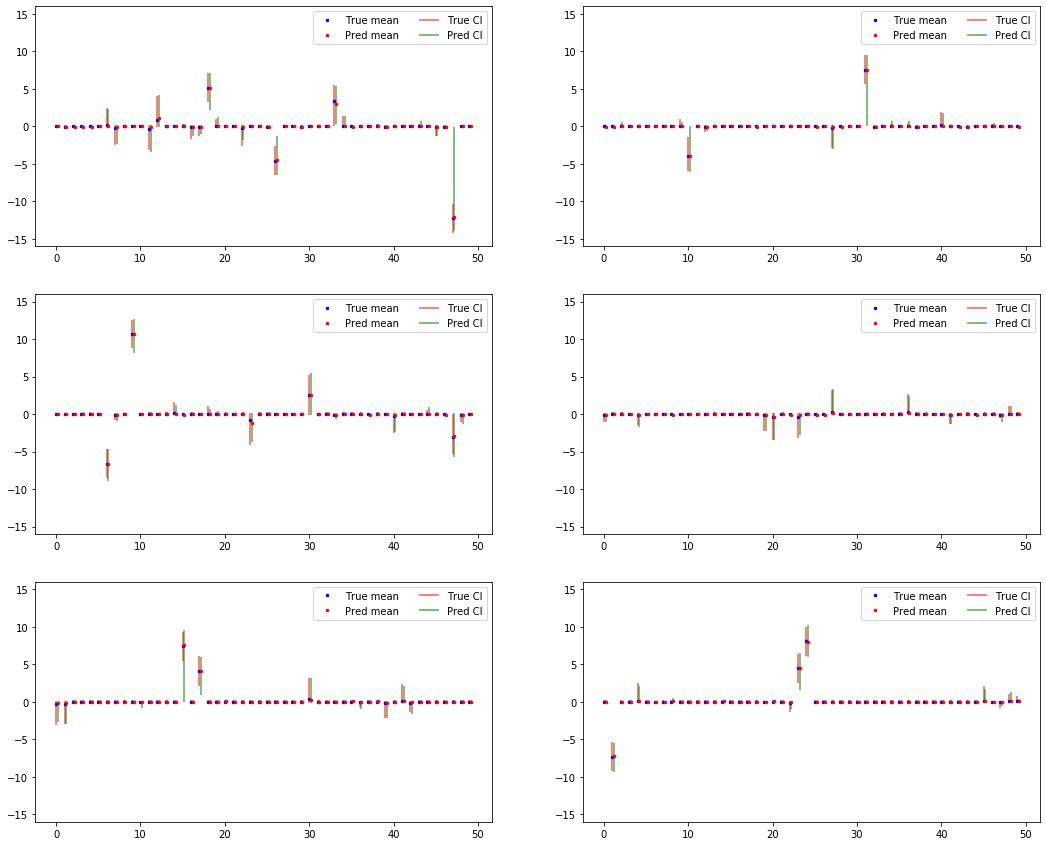

In [17]:
subset = np.where(np.abs(beta_test[:10000,:])>2)[0]
t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
rng.shuffle(subset)
subset = subset[:6]    

plt.figure(figsize=(18,15))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(p), true_mean[idx], '.b', ms=5)
    plt.plot(np.arange(p)+0.2, pred_mean[idx], '.r', ms=5)
    plt.vlines(np.arange(p), true_q025[idx], true_q975[idx], color='red', alpha=0.5, lw=2)
    plt.vlines(np.arange(p)+0.2, pred_q025[idx], pred_q975[idx], color='green', alpha=0.5, lw=2)
    plt.legend(['True mean', 'Pred mean', 'True CI', 'Pred CI'], ncol=2)
    plt.ylim(-16,16)
plt.show()

### MSE and Loss Analysis

MSE between true posterior quantiles and predicted quantiles.

In [18]:
mse_q025 = np.mean((true_q025 - pred_q025[:10000,:])**2, 0)
mse_q975 = np.mean((true_q975 - pred_q975[:10000,:])**2, 0)

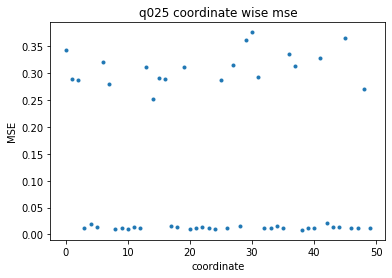

In [19]:
plt.plot(mse_q025,'.')
plt.xlabel('coordinate')
plt.ylabel('MSE')
plt.title('q025 coordinate wise mse')
plt.show()

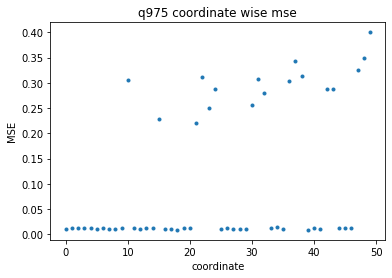

In [20]:
plt.plot(mse_q975,'.')
plt.xlabel('coordinate')
plt.ylabel('MSE')
plt.title('q975 coordinate wise mse')
plt.show()

In [21]:
'''
Compute test set loss
'''
q025_loss = np.mean(np.maximum(0.025*(beta_test-pred_q025),0.975*(pred_q025-beta_test)), 0)
q975_loss = np.mean(np.maximum(0.975*(beta_test-pred_q975),0.025*(pred_q975-beta_test)), 0)

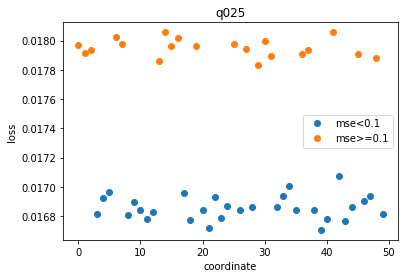

In [22]:
plt.plot(np.where(mse_q025<0.1)[0].reshape(-1), q025_loss[np.where(mse_q025<0.1)], 'o')
plt.plot(np.where(mse_q025>=0.1)[0].reshape(-1), q025_loss[np.where(mse_q025>=0.1)], 'o')
plt.legend(['mse<0.1', 'mse>=0.1'])
plt.ylabel('loss')
plt.xlabel('coordinate')
plt.title('q025')
plt.show()

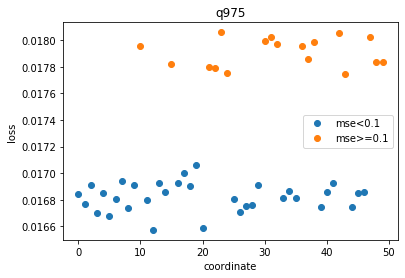

In [23]:
plt.plot(np.where(mse_q975<0.1)[0].reshape(-1), q975_loss[np.where(mse_q975<0.1)], 'o')
plt.plot(np.where(mse_q975>=0.1)[0].reshape(-1), q975_loss[np.where(mse_q975>=0.1)], 'o')
plt.legend(['mse<0.1', 'mse>=0.1'])
plt.ylabel('loss')
plt.xlabel('coordinate')
plt.title('q975')
plt.show()

### Last layers' bias

In [24]:
paras_q025 = []
for name, para in md_q025.named_parameters():
    print(name)
    paras_q025.append(copy.deepcopy(para))

fc_final.weight
fc_final.bias
fc.0.weight
fc.0.bias
fc.1.weight
fc.1.bias


In [25]:
q025_final_bias = paras_q025[1].cpu().detach().numpy()

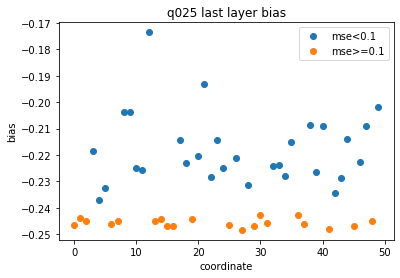

In [26]:
plt.plot(np.where(mse_q025<0.1)[0].reshape(-1), q025_final_bias[np.where(mse_q025<0.1)], 'o')
plt.plot(np.where(mse_q025>=0.1)[0].reshape(-1), q025_final_bias[np.where(mse_q025>=0.1)], 'o')
plt.legend(['mse<0.1', 'mse>=0.1'])
plt.ylabel('bias')
plt.xlabel('coordinate')
plt.title('q025 last layer bias')
plt.show()

In [27]:
paras_q975 = []
for name, para in md_q975.named_parameters():
    print(name)
    paras_q975.append(copy.deepcopy(para))

fc_final.weight
fc_final.bias
fc.0.weight
fc.0.bias
fc.1.weight
fc.1.bias


In [28]:
q975_final_bias = paras_q975[1].cpu().detach().numpy()

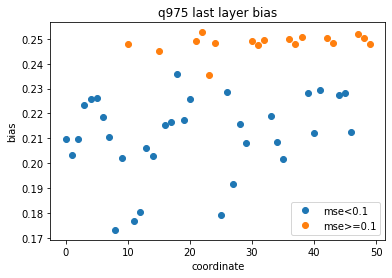

In [29]:
plt.plot(np.where(mse_q975<0.1)[0].reshape(-1), q975_final_bias[np.where(mse_q975<0.1)], 'o')
plt.plot(np.where(mse_q975>=0.1)[0].reshape(-1), q975_final_bias[np.where(mse_q975>=0.1)], 'o')
plt.legend(['mse<0.1', 'mse>=0.1'])
plt.ylabel('bias')
plt.xlabel('coordinate')
plt.title('q975 last layer bias')
plt.show()

## Subset Models

In [30]:
s = (1, 20)
md_q025_1_20 = MLP_variant(p, 20, [1024, 1024], 'leakyrelu').to(device)
optimizer = torch.optim.Adam(md_q025_1_20.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30, 40, 50, 60, 70, 80], gamma=0.4)
train_losses, val_losses = train_model_with_generator(md_q025_1_20, generator, optimizer, epochs=100, 
                                      batch_size=256, iteration_per_epoch=4000, loss_type='quantile',
                                      q=0.025, val_data=valid_dataloader, scheduler=scheduler,
                                      mean=mean, std=std, subset=s)

Epoch: 1
Train loss: 0.02144
Val loss: 0.01947
Epoch: 2
Train loss: 0.01924
Val loss: 0.01895
Epoch: 3
Train loss: 0.01897
Val loss: 0.01872
Epoch: 4
Train loss: 0.01888
Val loss: 0.01862
Epoch: 5
Train loss: 0.01873
Val loss: 0.01855
Epoch: 6
Train loss: 0.01857
Val loss: 0.01838
Epoch: 7
Train loss: 0.01843
Val loss: 0.01823
Epoch: 8
Train loss: 0.01834
Val loss: 0.01819
Epoch: 9
Train loss: 0.01828
Val loss: 0.01813
Epoch: 10
Train loss: 0.01816
Val loss: 0.01810
Epoch: 11
Train loss: 0.01813
Val loss: 0.01808
Epoch: 12
Train loss: 0.01809
Val loss: 0.01789
Epoch: 13
Train loss: 0.01805
Val loss: 0.01780
Epoch: 14
Train loss: 0.01805
Val loss: 0.01790
Epoch: 15
Train loss: 0.01804
Val loss: 0.01778
Epoch: 16
Train loss: 0.01799
Val loss: 0.01780
Epoch: 17
Train loss: 0.01797
Val loss: 0.01782
Epoch: 18
Train loss: 0.01794
Val loss: 0.01783
Epoch: 19
Train loss: 0.01789
Val loss: 0.01771
Epoch: 20
Train loss: 0.01785
Val loss: 0.01770
Epoch: 21
Train loss: 0.01749
Val loss: 0.01729
E

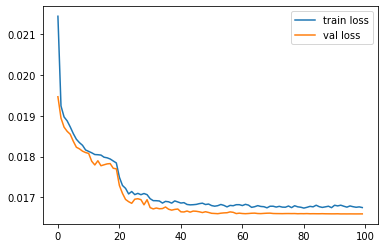

In [31]:
show_loss(train_losses, val_losses)

In [32]:
md_q975_1_20 = MLP_variant(p, 20, [1024, 1024], 'leakyrelu').to(device)
optimizer = torch.optim.Adam(md_q975_1_20.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30, 40, 50, 60, 70, 80], gamma=0.4)
train_losses, val_losses = train_model_with_generator(md_q975_1_20, generator, optimizer, epochs=100, 
                                      batch_size=256, iteration_per_epoch=4000, loss_type='quantile',
                                      q=0.975, val_data=valid_dataloader, scheduler=scheduler,
                                      mean=mean, std=std, subset=s)

Epoch: 1
Train loss: 0.02144
Val loss: 0.01933
Epoch: 2
Train loss: 0.01929
Val loss: 0.01901
Epoch: 3
Train loss: 0.01892
Val loss: 0.01858
Epoch: 4
Train loss: 0.01875
Val loss: 0.01842
Epoch: 5
Train loss: 0.01863
Val loss: 0.01831
Epoch: 6
Train loss: 0.01847
Val loss: 0.01805
Epoch: 7
Train loss: 0.01842
Val loss: 0.01812
Epoch: 8
Train loss: 0.01834
Val loss: 0.01810
Epoch: 9
Train loss: 0.01827
Val loss: 0.01796
Epoch: 10
Train loss: 0.01825
Val loss: 0.01795
Epoch: 11
Train loss: 0.01818
Val loss: 0.01790
Epoch: 12
Train loss: 0.01810
Val loss: 0.01774
Epoch: 13
Train loss: 0.01801
Val loss: 0.01772
Epoch: 14
Train loss: 0.01797
Val loss: 0.01755
Epoch: 15
Train loss: 0.01790
Val loss: 0.01764
Epoch: 16
Train loss: 0.01792
Val loss: 0.01769
Epoch: 17
Train loss: 0.01790
Val loss: 0.01757
Epoch: 18
Train loss: 0.01787
Val loss: 0.01762
Epoch: 19
Train loss: 0.01783
Val loss: 0.01759
Epoch: 20
Train loss: 0.01781
Val loss: 0.01751
Epoch: 21
Train loss: 0.01740
Val loss: 0.01693
E

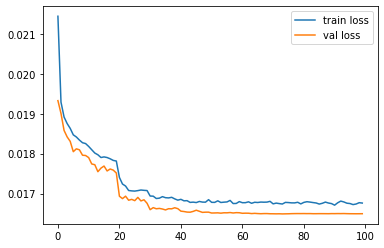

In [33]:
show_loss(train_losses, val_losses)

In [34]:
s = (21, 40)
md_q025_21_40 = MLP_variant(p, 20, [1024, 1024], 'leakyrelu').to(device)
optimizer = torch.optim.Adam(md_q025_21_40.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30, 40, 50, 60, 70, 80], gamma=0.4)
train_losses, val_losses = train_model_with_generator(md_q025_21_40, generator, optimizer, epochs=100, 
                                      batch_size=256, iteration_per_epoch=4000, loss_type='quantile',
                                      q=0.025, val_data=valid_dataloader, scheduler=scheduler,
                                      mean=mean, std=std, subset=s)

Epoch: 1
Train loss: 0.02146
Val loss: 0.01984
Epoch: 2
Train loss: 0.01925
Val loss: 0.01982
Epoch: 3
Train loss: 0.01901
Val loss: 0.01939
Epoch: 4
Train loss: 0.01886
Val loss: 0.01928
Epoch: 5
Train loss: 0.01877
Val loss: 0.01914
Epoch: 6
Train loss: 0.01872
Val loss: 0.01922
Epoch: 7
Train loss: 0.01867
Val loss: 0.01918
Epoch: 8
Train loss: 0.01851
Val loss: 0.01904
Epoch: 9
Train loss: 0.01846
Val loss: 0.01885
Epoch: 10
Train loss: 0.01839
Val loss: 0.01896
Epoch: 11
Train loss: 0.01820
Val loss: 0.01863
Epoch: 12
Train loss: 0.01806
Val loss: 0.01865
Epoch: 13
Train loss: 0.01806
Val loss: 0.01853
Epoch: 14
Train loss: 0.01800
Val loss: 0.01840
Epoch: 15
Train loss: 0.01795
Val loss: 0.01847
Epoch: 16
Train loss: 0.01793
Val loss: 0.01846
Epoch: 17
Train loss: 0.01788
Val loss: 0.01833
Epoch: 18
Train loss: 0.01784
Val loss: 0.01829
Epoch: 19
Train loss: 0.01787
Val loss: 0.01834
Epoch: 20
Train loss: 0.01782
Val loss: 0.01835
Epoch: 21
Train loss: 0.01741
Val loss: 0.01782
E

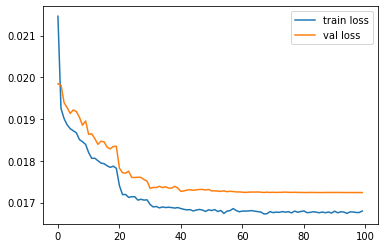

In [35]:
show_loss(train_losses, val_losses)

In [36]:
md_q975_21_40 = MLP_variant(p, 20, [1024, 1024], 'leakyrelu').to(device)
optimizer = torch.optim.Adam(md_q975_21_40.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30, 40, 50, 60, 70, 80], gamma=0.4)
train_losses, val_losses = train_model_with_generator(md_q975_21_40, generator, optimizer, epochs=100, 
                                      batch_size=256, iteration_per_epoch=4000, loss_type='quantile',
                                      q=0.975, val_data=valid_dataloader, scheduler=scheduler,
                                      mean=mean, std=std, subset=s)

Epoch: 1
Train loss: 0.02142
Val loss: 0.01934
Epoch: 2
Train loss: 0.01928
Val loss: 0.01883
Epoch: 3
Train loss: 0.01898
Val loss: 0.01873
Epoch: 4
Train loss: 0.01879
Val loss: 0.01868
Epoch: 5
Train loss: 0.01864
Val loss: 0.01842
Epoch: 6
Train loss: 0.01853
Val loss: 0.01820
Epoch: 7
Train loss: 0.01826
Val loss: 0.01812
Epoch: 8
Train loss: 0.01813
Val loss: 0.01805
Epoch: 9
Train loss: 0.01810
Val loss: 0.01800
Epoch: 10
Train loss: 0.01803
Val loss: 0.01782
Epoch: 11
Train loss: 0.01792
Val loss: 0.01774
Epoch: 12
Train loss: 0.01790
Val loss: 0.01772
Epoch: 13
Train loss: 0.01793
Val loss: 0.01783
Epoch: 14
Train loss: 0.01782
Val loss: 0.01770
Epoch: 15
Train loss: 0.01780
Val loss: 0.01759
Epoch: 16
Train loss: 0.01777
Val loss: 0.01758
Epoch: 17
Train loss: 0.01780
Val loss: 0.01766
Epoch: 18
Train loss: 0.01771
Val loss: 0.01762
Epoch: 19
Train loss: 0.01777
Val loss: 0.01758
Epoch: 20
Train loss: 0.01770
Val loss: 0.01764
Epoch: 21
Train loss: 0.01729
Val loss: 0.01721
E

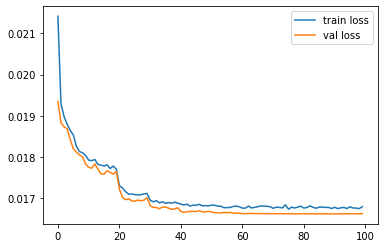

In [37]:
show_loss(train_losses, val_losses)

In [38]:
s = (41, 50)
md_q025_41_50 = MLP_variant(p, 10, [1024, 1024], 'leakyrelu').to(device)
optimizer = torch.optim.Adam(md_q025_41_50.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30, 40, 50, 60, 70, 80], gamma=0.4)
train_losses, val_losses = train_model_with_generator(md_q025_41_50, generator, optimizer, epochs=100, 
                                      batch_size=256, iteration_per_epoch=4000, loss_type='quantile',
                                      q=0.025, val_data=valid_dataloader, scheduler=scheduler,
                                      mean=mean, std=std, subset=s)

Epoch: 1
Train loss: 0.02078
Val loss: 0.01900
Epoch: 2
Train loss: 0.01890
Val loss: 0.01842
Epoch: 3
Train loss: 0.01823
Val loss: 0.01791
Epoch: 4
Train loss: 0.01789
Val loss: 0.01784
Epoch: 5
Train loss: 0.01784
Val loss: 0.01783
Epoch: 6
Train loss: 0.01776
Val loss: 0.01775
Epoch: 7
Train loss: 0.01770
Val loss: 0.01758
Epoch: 8
Train loss: 0.01764
Val loss: 0.01745
Epoch: 9
Train loss: 0.01764
Val loss: 0.01743
Epoch: 10
Train loss: 0.01757
Val loss: 0.01751
Epoch: 11
Train loss: 0.01755
Val loss: 0.01771
Epoch: 12
Train loss: 0.01757
Val loss: 0.01746
Epoch: 13
Train loss: 0.01747
Val loss: 0.01734
Epoch: 14
Train loss: 0.01747
Val loss: 0.01738
Epoch: 15
Train loss: 0.01751
Val loss: 0.01739
Epoch: 16
Train loss: 0.01746
Val loss: 0.01737
Epoch: 17
Train loss: 0.01741
Val loss: 0.01735
Epoch: 18
Train loss: 0.01738
Val loss: 0.01722
Epoch: 19
Train loss: 0.01736
Val loss: 0.01737
Epoch: 20
Train loss: 0.01735
Val loss: 0.01728
Epoch: 21
Train loss: 0.01707
Val loss: 0.01695
E

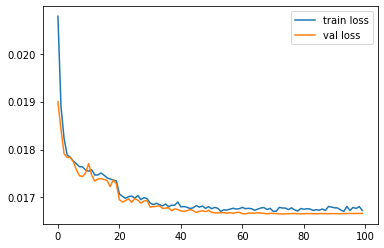

In [39]:
show_loss(train_losses, val_losses)

In [40]:
md_q975_41_50 = MLP_variant(p, 10, [1024, 1024], 'leakyrelu').to(device)
optimizer = torch.optim.Adam(md_q975_41_50.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30, 40, 50, 60, 70, 80], gamma=0.4)
train_losses, val_losses = train_model_with_generator(md_q975_41_50, generator, optimizer, epochs=100, 
                                      batch_size=256, iteration_per_epoch=4000, loss_type='quantile',
                                      q=0.975, val_data=valid_dataloader, scheduler=scheduler,
                                      mean=mean, std=std, subset=s)

Epoch: 1
Train loss: 0.02079
Val loss: 0.01847
Epoch: 2
Train loss: 0.01891
Val loss: 0.01818
Epoch: 3
Train loss: 0.01825
Val loss: 0.01751
Epoch: 4
Train loss: 0.01803
Val loss: 0.01722
Epoch: 5
Train loss: 0.01781
Val loss: 0.01705
Epoch: 6
Train loss: 0.01775
Val loss: 0.01712
Epoch: 7
Train loss: 0.01771
Val loss: 0.01705
Epoch: 8
Train loss: 0.01771
Val loss: 0.01705
Epoch: 9
Train loss: 0.01758
Val loss: 0.01709
Epoch: 10
Train loss: 0.01761
Val loss: 0.01681
Epoch: 11
Train loss: 0.01755
Val loss: 0.01691
Epoch: 12
Train loss: 0.01751
Val loss: 0.01689
Epoch: 13
Train loss: 0.01749
Val loss: 0.01662
Epoch: 14
Train loss: 0.01747
Val loss: 0.01684
Epoch: 15
Train loss: 0.01747
Val loss: 0.01668
Epoch: 16
Train loss: 0.01749
Val loss: 0.01680
Epoch: 17
Train loss: 0.01738
Val loss: 0.01670
Epoch: 18
Train loss: 0.01737
Val loss: 0.01672
Epoch: 19
Train loss: 0.01739
Val loss: 0.01680
Epoch: 20
Train loss: 0.01739
Val loss: 0.01684
Epoch: 21
Train loss: 0.01705
Val loss: 0.01634
E

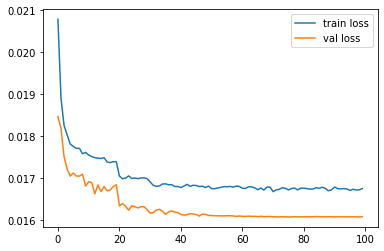

In [41]:
show_loss(train_losses, val_losses)

In [42]:
pred_q025_1_20 = predict(md_q025_1_20, Y_test_normalized)
pred_q975_1_20 = predict(md_q975_1_20, Y_test_normalized)
pred_q025_21_40 = predict(md_q025_21_40, Y_test_normalized)
pred_q975_21_40 = predict(md_q975_21_40, Y_test_normalized)
pred_q025_41_50 = predict(md_q025_41_50, Y_test_normalized)
pred_q975_41_50 = predict(md_q975_41_50, Y_test_normalized)
pred_q025_c = np.c_[pred_q025_1_20, pred_q025_21_40, pred_q025_41_50]
pred_q975_c = np.c_[pred_q975_1_20, pred_q975_21_40, pred_q975_41_50]

Posterior mean predicted using previous mean model

In [43]:
pred_mean = predict(md_mean, Y_test_normalized)

In [44]:
mse_q025_c = np.mean((true_q025 - pred_q025_c[:10000,:])**2, 0)
mse_q975_c = np.mean((true_q975 - pred_q975_c[:10000,:])**2, 0)

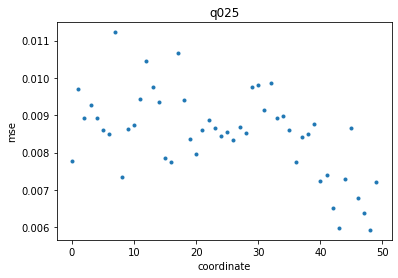

In [45]:
plt.plot(mse_q025_c, '.')
plt.ylabel('mse') 
plt.xlabel('coordinate')
plt.title('q025')
plt.show()

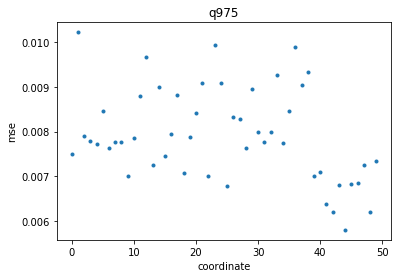

In [46]:
plt.plot(mse_q975_c, '.')
plt.ylabel('mse') 
plt.xlabel('coordinate')
plt.title('q975')
plt.show()

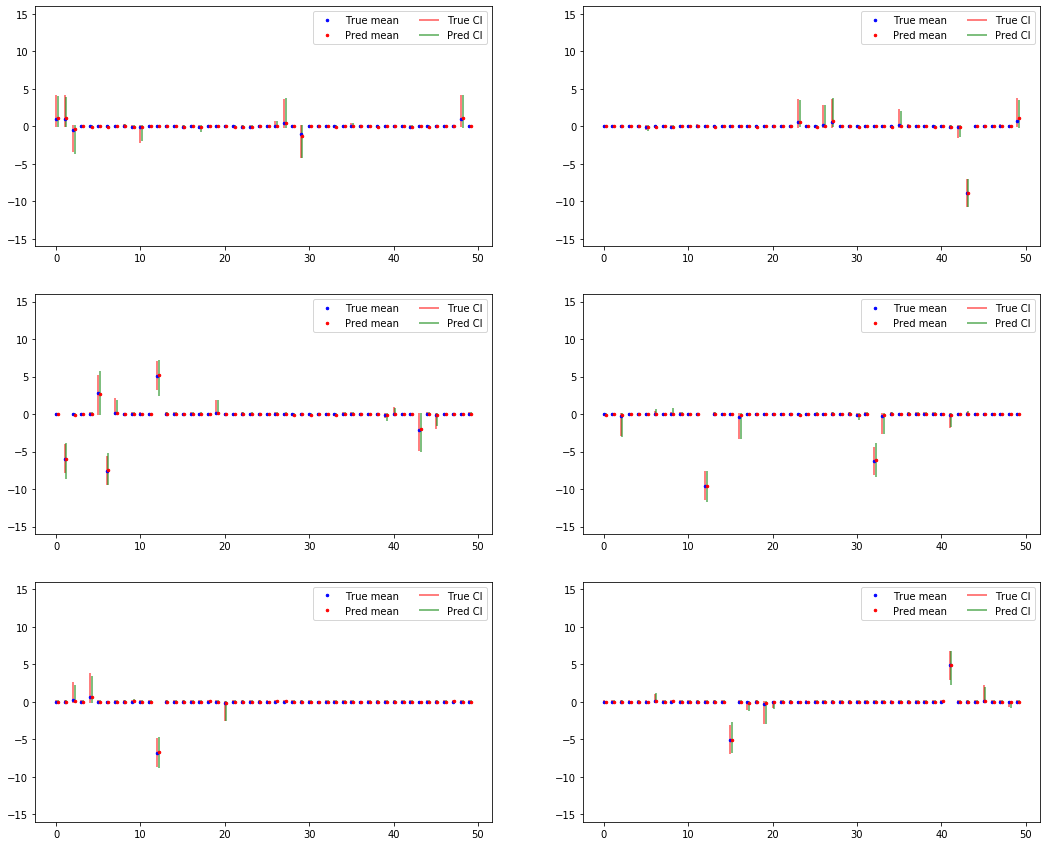

In [47]:
subset = np.where(np.abs(beta_test[:10000,:])>2)[0]
t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
rng.shuffle(subset)
subset = subset[:6]    

plt.figure(figsize=(18,15))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(p), true_mean[idx], '.b', ms=5)
    plt.plot(np.arange(p)+0.2, pred_mean[idx], '.r', ms=5)
    plt.vlines(np.arange(p), true_q025[idx], true_q975[idx], color='red', alpha=0.5, lw=2)
    plt.vlines(np.arange(p)+0.2, pred_q025_c[idx], pred_q975_c[idx], color='green', alpha=0.5, lw=2)
    plt.legend(['True mean', 'Pred mean', 'True CI', 'Pred CI'], ncol=2)
    plt.ylim(-16,16)
plt.show()

### Output only the quantile of $\beta_1$

In [48]:
s = (1, 1)
md_q025_1 = MLP_variant(p, 1, [1024, 1024], 'leakyrelu').to(device)
optimizer = torch.optim.Adam(md_q025_1.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30, 40, 50, 60, 70, 80], gamma=0.4)
train_losses, val_losses = train_model_with_generator(md_q025_1, generator, optimizer, epochs=100, 
                                      batch_size=256, iteration_per_epoch=4000, loss_type='quantile',
                                      q=0.025, val_data=valid_dataloader, scheduler=scheduler,
                                      mean=mean, std=std, subset=s)

Epoch: 1
Train loss: 0.01971
Val loss: 0.01688
Epoch: 2
Train loss: 0.01808
Val loss: 0.01732
Epoch: 3
Train loss: 0.01799
Val loss: 0.01678
Epoch: 4
Train loss: 0.01784
Val loss: 0.01686
Epoch: 5
Train loss: 0.01760
Val loss: 0.01656
Epoch: 6
Train loss: 0.01756
Val loss: 0.01677
Epoch: 7
Train loss: 0.01763
Val loss: 0.01672
Epoch: 8
Train loss: 0.01736
Val loss: 0.01742
Epoch: 9
Train loss: 0.01723
Val loss: 0.01624
Epoch: 10
Train loss: 0.01732
Val loss: 0.01647
Epoch: 11
Train loss: 0.01733
Val loss: 0.01662
Epoch: 12
Train loss: 0.01742
Val loss: 0.01636
Epoch: 13
Train loss: 0.01709
Val loss: 0.01614
Epoch: 14
Train loss: 0.01711
Val loss: 0.01667
Epoch: 15
Train loss: 0.01719
Val loss: 0.01604
Epoch: 16
Train loss: 0.01727
Val loss: 0.01634
Epoch: 17
Train loss: 0.01715
Val loss: 0.01697
Epoch: 18
Train loss: 0.01707
Val loss: 0.01660
Epoch: 19
Train loss: 0.01726
Val loss: 0.01812
Epoch: 20
Train loss: 0.01718
Val loss: 0.01615
Epoch: 21
Train loss: 0.01678
Val loss: 0.01594
E

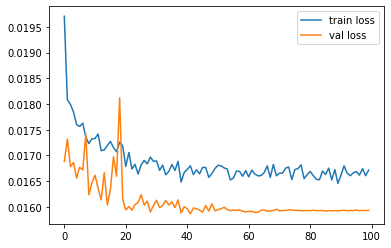

In [49]:
show_loss(train_losses, val_losses)

In [50]:
md_q975_1 = MLP_variant(p, 1, [1024, 1024], 'leakyrelu').to(device)
optimizer = torch.optim.Adam(md_q975_1.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30, 40, 50, 60, 70, 80], gamma=0.4)
train_losses, val_losses = train_model_with_generator(md_q975_1, generator, optimizer, epochs=100, 
                                      batch_size=256, iteration_per_epoch=4000, loss_type='quantile',
                                      q=0.975, val_data=valid_dataloader, scheduler=scheduler,
                                      mean=mean, std=std, subset=s)

Epoch: 1
Train loss: 0.01989
Val loss: 0.01857
Epoch: 2
Train loss: 0.01805
Val loss: 0.01880
Epoch: 3
Train loss: 0.01796
Val loss: 0.01864
Epoch: 4
Train loss: 0.01770
Val loss: 0.01860
Epoch: 5
Train loss: 0.01741
Val loss: 0.01832
Epoch: 6
Train loss: 0.01758
Val loss: 0.01850
Epoch: 7
Train loss: 0.01747
Val loss: 0.01828
Epoch: 8
Train loss: 0.01757
Val loss: 0.01873
Epoch: 9
Train loss: 0.01732
Val loss: 0.01836
Epoch: 10
Train loss: 0.01735
Val loss: 0.01859
Epoch: 11
Train loss: 0.01711
Val loss: 0.01800
Epoch: 12
Train loss: 0.01705
Val loss: 0.01880
Epoch: 13
Train loss: 0.01741
Val loss: 0.01817
Epoch: 14
Train loss: 0.01728
Val loss: 0.01791
Epoch: 15
Train loss: 0.01712
Val loss: 0.01821
Epoch: 16
Train loss: 0.01711
Val loss: 0.01815
Epoch: 17
Train loss: 0.01713
Val loss: 0.01803
Epoch: 18
Train loss: 0.01704
Val loss: 0.01845
Epoch: 19
Train loss: 0.01713
Val loss: 0.01815
Epoch: 20
Train loss: 0.01721
Val loss: 0.01788
Epoch: 21
Train loss: 0.01686
Val loss: 0.01771
E

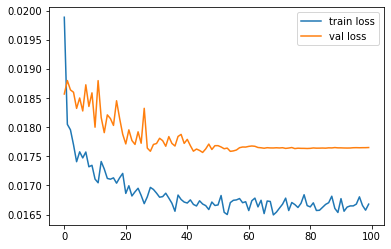

In [51]:
show_loss(train_losses, val_losses)

In [52]:
pred_q025_1 = predict(md_q025_1, Y_test_normalized)
pred_q975_1 = predict(md_q975_1, Y_test_normalized)

Overall MSE of 1-dimensional output model

In [53]:
print('q025: ', np.mean((true_q025[:,:1] - pred_q025_1[:10000,:])**2))
print('q975: ', np.mean((true_q975[:,:1] - pred_q975_1[:10000,:])**2))

q025:  0.00171274145035352
q975:  0.0014592825611138376
